In [1]:
import pandas as pd
from utils import evaluate
from sklearn.preprocessing import MinMaxScaler
from utils.evaluate import calculate_cosine_similarity
import re
csv_file_name_input = "job_4_temperature_llama2-70b-result.csv"
csv_file_name_output = "job_4_temperature_llama2-70b-result-simularity.csv"

/home/llama/Personal_Directories/srb/causalEnv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_answers(text):
    pattern = re.compile(r'<Answer>(.*?)</Answer>|<Answer>(.*?)<Answer>')
    matches = pattern.findall(text)
    contents = [match[0].strip() if match[0] else match[1].strip() for match in matches if match[0] or match[1]]
    result_str = '\n'.join(contents)
    if contents:  
        return True, result_str
    else:  
        return False, text


concatenated_result = pd.read_csv(csv_file_name_input)
concatenated_result.columns
concatenated_result["is_well_matching"], concatenated_result["generated_response_matching"]  = zip(*concatenated_result["full answer"].apply(extract_answers))

# Found 100% follow the instruction

ground_truth_responses = concatenated_result["ground_truth_response"].to_list()
generated_responses = concatenated_result["generated_response_matching"].to_list()

scores = evaluate.calculate_bleu_scores_smooth(
    ground_truth_responses, generated_responses
)

concatenated_result["generated_response_matching"] = concatenated_result["generated_response_matching"].str.replace("Your answer here\n", "")

concatenated_result['cosine_similarity'] = concatenated_result.apply(
    lambda row: calculate_cosine_similarity(row['generated_response_matching'][:512], row['ground_truth_response'][:512]),
    axis=1
)
concatenated_result["BLEU"] = scores
concatenated_result["temperature"] = concatenated_result["temperature"].astype(float)
concatenated_result["cosine_similarity"] = concatenated_result["cosine_similarity"].astype(float)
concatenated_result.to_csv(csv_file_name_output)

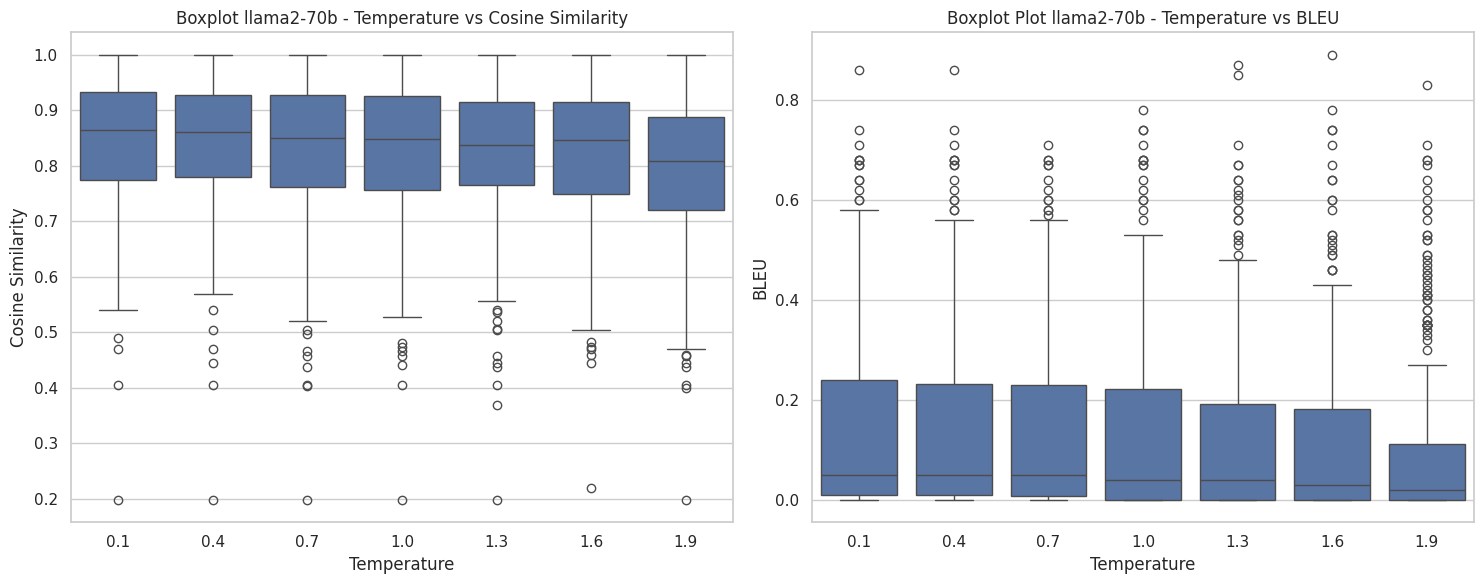

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Boxplot
sns.boxplot(
    x=concatenated_result["temperature"],
    y=concatenated_result["cosine_similarity"],
    ax=axes[0],
)
axes[0].set_title("Boxplot llama2-70b - Temperature vs Cosine Similarity")
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Cosine Similarity")

# Scatter plot for BLEU
sns.boxplot(
    x=concatenated_result["temperature"],
    y=concatenated_result["BLEU"],
    ax=axes[1],
)
axes[1].set_title("Boxplot Plot llama2-70b - Temperature vs BLEU")
axes[1].set_xlabel("Temperature")
axes[1].set_ylabel("BLEU")

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()